In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import math
import numpy as np
import os
import pandas as pd
import random
import shutil
import zipfile

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

# Data Processing
## Import Data
### Full Dataset

In [4]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-06-12 14:51:42--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.73.0.105, 2600:1405:800:1a2::e59, 2600:1405:800:1a6::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.73.0.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   311MB/s    in 2.5s    

2021-06-12 14:51:45 (311 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [35]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [40]:
print(os.path.abspath(os.getcwd()))

/home/jupyter/tfcert/Image Classification


In [46]:
base = '/home/jupyter/+data/cats-v-dogs'
train_dir = os.path.join(base, 'train')
validation_dir = os.path.join(base, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
try:
    shutil.rmtree(base, ignore_errors=True)
    os.mkdir(base)
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(train_cats_dir)
    os.mkdir(train_dogs_dir)
    os.mkdir(validation_cats_dir)
    os.mkdir(validation_dogs_dir)
except OSError:
    print("what")

In [47]:
def split_data(source, training, testing, split_size):
    image_list = os.listdir(source)
    len_list = len(image_list)
    shuffled_image_list = random.sample(image_list, len_list)
    train_size = int(len_list*split_size)
    for image in image_list[:train_size]:
        image_path = os.path.join(source, image)
        destination = os.path.join(training, image)
        if os.path.getsize(image_path) == 0:
            print(f"{image} is zero length, so ignoring")
        else:
            copyfile(image_path, destination)
    for image in image_list[train_size:]:
        image_path = os.path.join(source, image)
        destination = os.path.join(testing, image)
        if os.path.getsize(image_path) == 0:
            print(f"{image} is zero length, so ignoring")
        else:
            copyfile(image_path, destination)

In [48]:
split_size = 0.9
split_data('/tmp/PetImages/Cat/', train_cats_dir, validation_cats_dir, split_size)
split_data('/tmp/PetImages/Dog/', train_dogs_dir, validation_dogs_dir, split_size)

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


In [50]:
print(len(os.listdir(train_cats_dir)))
print(len(os.listdir(train_dogs_dir)))
print(len(os.listdir(validation_cats_dir)))
print(len(os.listdir(validation_dogs_dir)))

11249
11249
1251
1251


### Filtered Dataset

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
      -O "/tmp/cats_and_dogs_filtered.zip"
!unzip -q "/tmp/cats_and_dogs_filtered.zip" -d "/home/jupyter/+data/"
base = "/home/jupyter/+data/cats_and_dogs_filtered"
train_dir_filtered = os.path.join(base, "train")
validation_dir_filtered = os.path.join(base, "validation")

## Visualize Images

In [51]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4
pic_index = 0

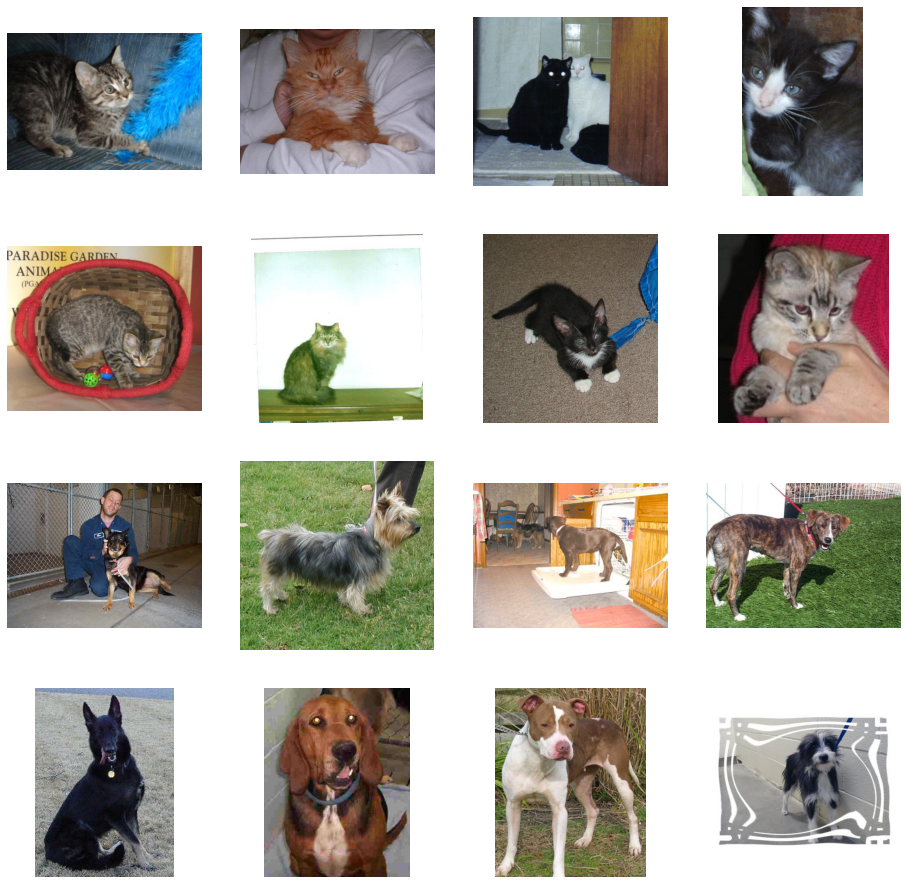

In [54]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

cat_fnames = os.listdir(train_cats_dir)
dog_fnames = os.listdir(train_dogs_dir)
cats = [os.path.join(train_cats_dir, fname) for fname in random.sample(cat_fnames, 8)]
dogs = [os.path.join(train_dogs_dir, fname) for fname in random.sample(dog_fnames, 8)]
for i, img_path in enumerate(cats+dogs):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
#     print(img.shape)
    plt.imshow(img)
plt.show()

# Model
## CNN

In [55]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [85]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

## ImageDataGenerator

In [101]:
def generator(source, augmented=False, batch_size=64):
    if augmented:
        datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     shear_range=0.2,
                                     zoom_range=0.2)
    else:
        datagen = ImageDataGenerator(rescale=1./255)
    data = datagen.flow_from_directory(
        source,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )
    return data

## Model Fitting

In [72]:
train_generator = generator(train_dir_filtered)
validation_generator = generator(validation_dir_filtered)
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator)

Found 2001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/15
32/32 [==============================] - 37s 1s/step - loss: 0.4342 - acc: 0.7981 - val_loss: 0.4551 - val_acc: 0.7800
Epoch 2/15
32/32 [==============================] - 37s 1s/step - loss: 0.4013 - acc: 0.8196 - val_loss: 0.4458 - val_acc: 0.7940
Epoch 3/15
32/32 [==============================] - 37s 1s/step - loss: 0.3773 - acc: 0.8376 - val_loss: 0.4679 - val_acc: 0.7844
Epoch 4/15
32/32 [==============================] - 37s 1s/step - loss: 0.3504 - acc: 0.8491 - val_loss: 0.4531 - val_acc: 0.7908
Epoch 5/15
32/32 [==============================] - 37s 1s/step - loss: 0.3305 - acc: 0.8576 - val_loss: 0.4501 - val_acc: 0.7908
Epoch 6/15
32/32 [==============================] - 37s 1s/step - loss: 0.3119 - acc: 0.8666 - val_loss: 0.4252 - val_acc: 0.8084
Epoch 7/15
32/32 [==============================] - 38s 1s/step - loss: 0.3081 - acc: 0.8701 - val_loss: 0.4445 - val_acc: 0.8020
Epoch 

In [81]:
def plot_learning_curves(history):
    acc = history.history["acc"]
    val_acc = history.history["val_acc"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(acc))
    plt.figure(figsize=(16, 5))
    acc_plt = plt.subplot(1, 2, 1)
    acc_plt.plot(epochs, acc, "bo", label="Training accuracy")
    acc_plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.legend()
#     plt.gca().set_ylim(0, 1)
    
    loss_plt = plt.subplot(1, 2, 2)
    loss_plt.plot(epochs, loss, "bo", label="Training loss")
    loss_plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.legend()
#     plt.gca().set_ylim(0, 1)
    plt.show()

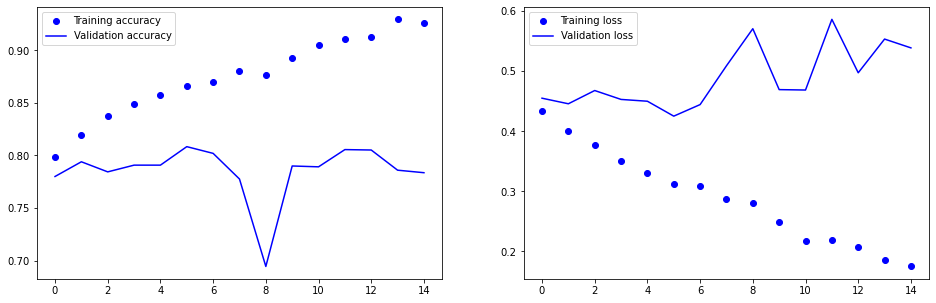

In [82]:
plot_learning_curves(history)

In [102]:
train_generator = generator(train_dir_filtered, augmented=True)
validation_generator = generator(validation_dir_filtered)
# history_aug = model.fit(train_generator,
#                         epochs=20,
#                         validation_data=validation_generator)

Found 2001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


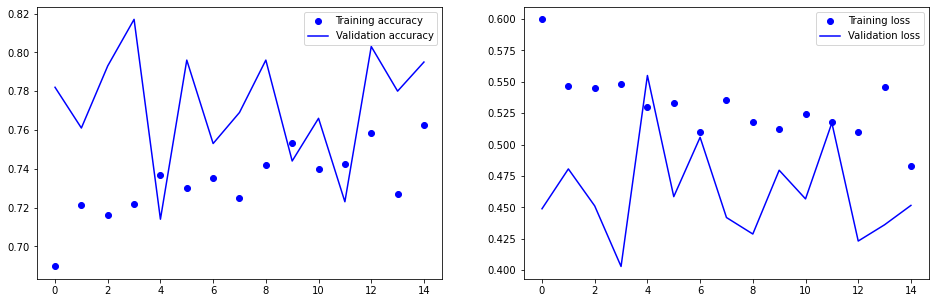

In [84]:
plot_learning_curves(history_aug)

## Tranfer Learning
### ResNet-50

In [86]:
import tensorflow_hub as hub
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

resnet = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub.KerasLayer(resnet_url, trainable=False),
    keras.layers.Dense(1, activation="sigmoid")
])
resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [87]:
resnet.compile(optimizer="rmsprop",
               loss="binary_crossentropy",
               metrics = ["acc"])

In [89]:
resnet_history = resnet.fit(train_generator,
                            epochs=15,
                            validation_data=validation_generator)

Epoch 1/15
32/32 [==============================] - 124s 4s/step - loss: 0.3900 - acc: 0.8321 - val_loss: 0.1499 - val_acc: 0.9470
Epoch 2/15
32/32 [==============================] - 123s 4s/step - loss: 0.1844 - acc: 0.9210 - val_loss: 0.1060 - val_acc: 0.9610
Epoch 3/15
32/32 [==============================] - 123s 4s/step - loss: 0.1687 - acc: 0.9295 - val_loss: 0.1123 - val_acc: 0.9560
Epoch 4/15
32/32 [==============================] - 124s 4s/step - loss: 0.1424 - acc: 0.9415 - val_loss: 0.0994 - val_acc: 0.9610
Epoch 5/15
32/32 [==============================] - 124s 4s/step - loss: 0.1397 - acc: 0.9435 - val_loss: 0.0901 - val_acc: 0.9700
Epoch 6/15
32/32 [==============================] - 121s 4s/step - loss: 0.1225 - acc: 0.9440 - val_loss: 0.0961 - val_acc: 0.9630
Epoch 7/15
32/32 [==============================] - 122s 4s/step - loss: 0.1408 - acc: 0.9455 - val_loss: 0.0898 - val_acc: 0.9710
Epoch 8/15
32/32 [==============================] - 123s 4s/step - loss: 0.1358 - a

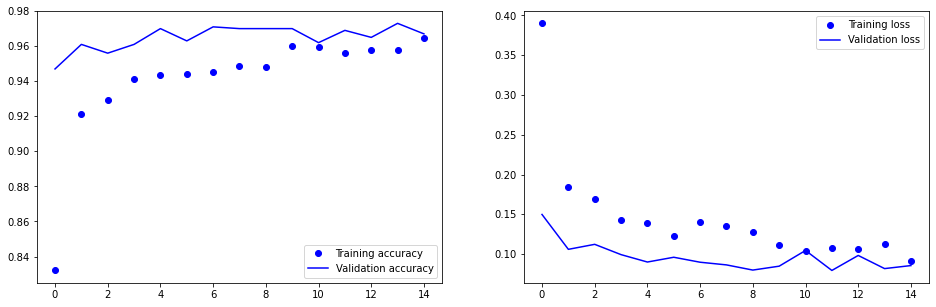

In [91]:
plot_learning_curves(resnet_history)

### MobileNetV2

In [98]:
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

mobilenet = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub.KerasLayer(mobilenet_url, trainable=False),
    keras.layers.Dense(1, activation="sigmoid")
])
mobilenet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [99]:
mobilenet.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics = ["acc"])

In [103]:
mobilenet_history = mobilenet.fit(train_generator,
                                  epochs=20,
                                  validation_data=validation_generator)

Epoch 1/20
32/32 [==============================] - 61s 2s/step - loss: 0.2669 - acc: 0.9075 - val_loss: 0.1119 - val_acc: 0.9770
Epoch 2/20
32/32 [==============================] - 60s 2s/step - loss: 0.1380 - acc: 0.9540 - val_loss: 0.0755 - val_acc: 0.9840
Epoch 3/20
32/32 [==============================] - 59s 2s/step - loss: 0.1092 - acc: 0.9655 - val_loss: 0.0593 - val_acc: 0.9830
Epoch 4/20
32/32 [==============================] - 60s 2s/step - loss: 0.0884 - acc: 0.9690 - val_loss: 0.0538 - val_acc: 0.9830
Epoch 5/20
32/32 [==============================] - 60s 2s/step - loss: 0.0921 - acc: 0.9645 - val_loss: 0.0488 - val_acc: 0.9840
Epoch 6/20
32/32 [==============================] - 61s 2s/step - loss: 0.0825 - acc: 0.9710 - val_loss: 0.0649 - val_acc: 0.9750
Epoch 7/20
32/32 [==============================] - 60s 2s/step - loss: 0.0696 - acc: 0.9755 - val_loss: 0.0467 - val_acc: 0.9820
Epoch 8/20
32/32 [==============================] - 60s 2s/step - loss: 0.0724 - acc: 0.97

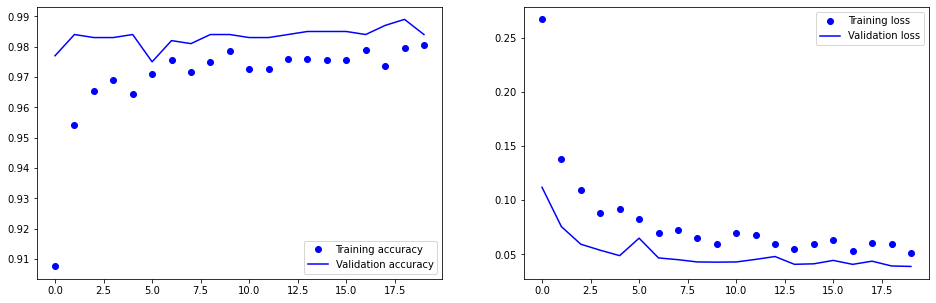

In [104]:
plot_learning_curves(mobilenet_history)